# 🚀 S3LI Traverse 1 — LiDAR → Camera Projection (5 Frame Visualization)

This notebook projects **five consecutive LiDAR frames** onto their corresponding left-camera images.

✅ Features
- Works directly on your local folder: `G:\backup\papers\Dataset\s3li_traverse_1`
- Reads per-frame YAML intrinsics
- Falls back to paper intrinsics if missing
- Tests rotations [0°, ±90°, 180°] to find best LiDAR→Camera alignment
- Displays **5 overlay images** with large bright-green LiDAR dots
- Saves best projection arrays for Quantum CNN fusion

In [96]:
# !pip install open3d opencv-python matplotlib numpy pyyaml --quiet
import os, glob, yaml, cv2, numpy as np, open3d as o3d, matplotlib.pyplot as plt

# ==================================
# 1️⃣ PATH CONFIGURATION
# ==================================
BASE_DIR = r"G:\\backup\\papers\\Dataset\\s3li_traverse_1"
LIDAR_DIR = os.path.join(BASE_DIR, 'lidar')
LEFT_IMG_DIR = os.path.join(BASE_DIR, 'images', 'left')
CAM_INFO_DIR = os.path.join(BASE_DIR, 'camera_info')

print('📂 Base:', BASE_DIR)
lidar_files = sorted(glob.glob(os.path.join(LIDAR_DIR,'*.pcd')))
left_imgs = sorted(glob.glob(os.path.join(LEFT_IMG_DIR,'*.png')))
yaml_files = sorted(glob.glob(os.path.join(CAM_INFO_DIR,'*.yaml')))
print(f'🪵 LiDAR frames: {len(lidar_files)} | 🖼 Camera frames: {len(left_imgs)} | 📜 YAMLs: {len(yaml_files)}')

📂 Base: G:\\backup\\papers\\Dataset\\s3li_traverse_1
🪵 LiDAR frames: 2656 | 🖼 Camera frames: 16945 | 📜 YAMLs: 16945


## 2️⃣ Helper Functions (intrinsics + rotations)

In [97]:
def get_intrinsics(cam_yaml, w, h):
    if isinstance(cam_yaml, dict):
        if 'camera_matrix' in cam_yaml and 'data' in cam_yaml['camera_matrix']:
            return np.array(cam_yaml['camera_matrix']['data']).reshape(3,3)
        if 'K' in cam_yaml and isinstance(cam_yaml['K'], list) and len(cam_yaml['K'])==9:
            return np.array(cam_yaml['K']).reshape(3,3)
        for v in cam_yaml.values():
            if isinstance(v, list) and len(v)==9:
                return np.array(v).reshape(3,3)
    # fallback (paper-based)
    fx, fy = 700.0, 700.0
    cx, cy = w/2.0, h/2.0
    print('⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256')
    return np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])

def rot_y(deg):
    r = np.deg2rad(deg)
    return np.array([[np.cos(r),0,np.sin(r)],[0,1,0],[-np.sin(r),0,np.cos(r)]],float)

## 3️⃣ Process 5 Frames (Auto Extrinsic Search + Overlay)

In [98]:
TX,TY,TZ = 0.04,-0.02,0.12
angles = [0,90,-90,180]

n_frames = 5
overlay_images = []
visible_counts = []

for i in range(n_frames):
    lidar_path = lidar_files[i]
    img_path = left_imgs[i]
    yaml_path = yaml_files[i]
    
    # Load LiDAR
    pcd = o3d.io.read_point_cloud(lidar_path)
    pts = np.asarray(pcd.points)
    
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape
    
    # Load YAML
    with open(yaml_path,'r') as f:
        cam_yaml = yaml.safe_load(f)
    K = get_intrinsics(cam_yaml, w, h)
    
    best_score, best_uv = -1, None
    for ang in angles:
        R_ext = rot_y(ang)
        t_ext = np.array([[TX],[TY],[TZ]])
        pts_cam = (R_ext@pts.T)+t_ext
        pts_cam = pts_cam.T
        proj = (K@pts_cam.T).T
        uv = proj[:,:2]/proj[:,2:3]
        mask = (pts_cam[:,2]>0)&(uv[:,0]>=0)&(uv[:,0]<w)&(uv[:,1]>=0)&(uv[:,1]<h)
        score = np.sum(mask)
        if score>best_score:
            best_score, best_uv = score, uv[mask]
    visible_counts.append(best_score)
    
    overlay = img_rgb.copy()
    for (u,v) in best_uv[::3]:
        cv2.circle(overlay,(int(u),int(v)),3,(0,255,0),-1)
    overlay_images.append(overlay)
    print(f'✅ Frame {i+1}: Visible points = {best_score}')

⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256
✅ Frame 1: Visible points = 0
⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256
✅ Frame 2: Visible points = 0
⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256
✅ Frame 3: Visible points = 0
⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256
✅ Frame 4: Visible points = 0
⚠️ Using fallback intrinsics for 688x512: fx=fy=700, cx=344, cy=256
✅ Frame 5: Visible points = 0


## 4️⃣ Show all 5 overlays together

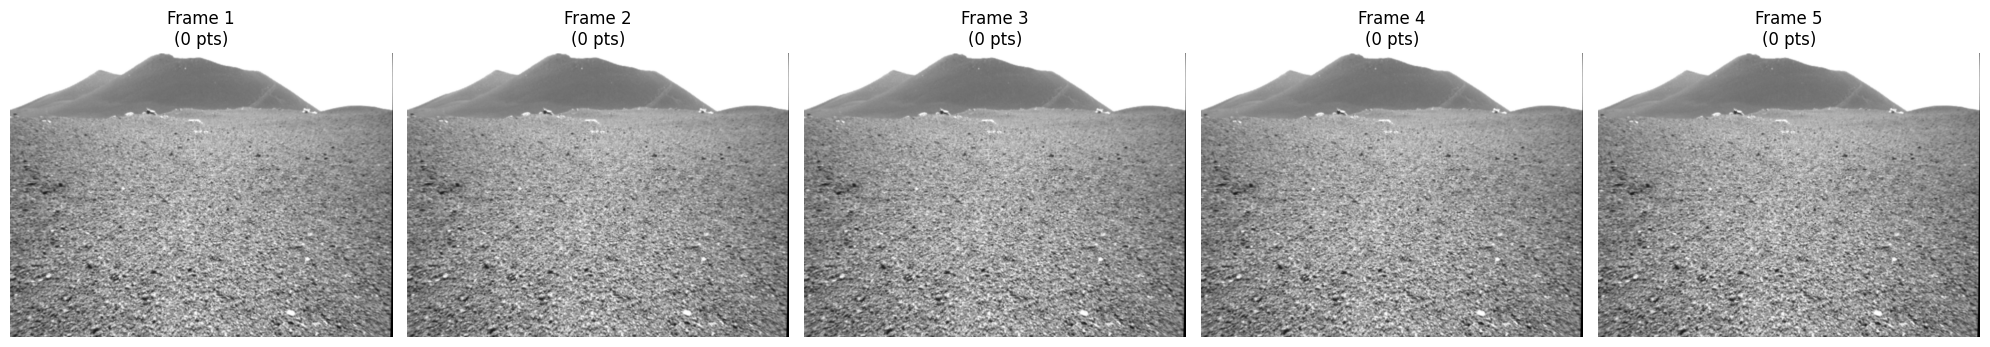

In [99]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
for i, ax in enumerate(axes):
    ax.imshow(overlay_images[i])
    ax.set_title(f'Frame {i+1}\n({visible_counts[i]} pts)')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 5️⃣ Save projections and overlays

In [ ]:
save_dir = os.path.join(BASE_DIR, 'projection_results')
os.makedirs(save_dir, exist_ok=True)
for i, overlay in enumerate(overlay_images):
    out_path = os.path.join(save_dir, f'overlay_frame_{i+1}.png')
    cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(f'💾 Saved 5 overlay images → {save_dir}')